In [ ]:
!pip install keras_vggface

In [ ]:
!pip install keras_applications

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
import cv2
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Face Detection Using Haar Cascade

In [ ]:
headshots_folder_name = '/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/Dataset/train/images'

# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", headshots_folder_name)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
        # path of the image
            path = os.path.join(root, file)

        # get the label name (name of the person)
        label = os.path.basename(root).replace(" ", ".").lower()

        # add the label (key) and its number (value)
        if not label in label_ids:
            label_ids[label] = current_id
            current_id += 1

        # load the image
        imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
        image_array = np.array(imgtest, "uint8")

        # get the faces detected in the image
        faces =  facecascade.detectMultiScale(imgtest,
            scaleFactor=1.1, minNeighbors=5)

        # if not exactly 1 face is detected, skip this photo
        if len(faces) != 1:
            print(f'---Photo skipped---\n')
        # remove the original image
            os.remove(path)
            continue

        # save the detected face(s) and associate
        # them with the label
        for (x_, y_, w, h) in faces:

            # draw the face detected
            face_detect = cv2.rectangle(imgtest,
                    (x_, y_),
                    (x_+w, y_+h),
                    (255, 0, 255), 2)
            plt.imshow(face_detect)
            plt.show()

            # resize the detected face to 224x224
            size = (image_width, image_height)

            # detected face region
            roi = image_array[y_: y_ + h, x_: x_ + w]

            # resize the detected head to target size
            resized_image = cv2.resize(roi, size)
            image_array = np.array(resized_image, "uint8")

            # remove the original image
            os.remove(path)

            # replace the image with only the face
            im = Image.fromarray(image_array)
            im.save(path)

In [ ]:
import os

def hitung_file(direktori):
    return len([f for f in os.listdir(direktori) if os.path.isfile(os.path.join(direktori, f))])

direktori = '/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/Dataset/valid/images'
jumlah_file = hitung_file(direktori)
print('Jumlah file:', jumlah_file)

Jumlah file: 368


# Face Recognition Using CNN and Transfer Learning from VGG16

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Convolution2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = \
    train_datagen.flow_from_directory(
'/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/face-detected/train',
target_size=(224,224),
batch_size=32,
class_mode='categorical')

valid_generator = \
    validation_datagen.flow_from_directory(
'/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/face-detected/test',
target_size=(224,224),
batch_size=32,
class_mode='categorical')

Found 687 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


In [ ]:
train_generator.class_indices.values()
# dict_values([0, 1, 2])
NO_CLASSES = len(train_generator.class_indices.values())

# Import VGG16 Pre-trained Model

In [ ]:
from keras_vggface.vggface import VGGFace
base_model = VGGFace(include_top=False,
model='vgg16',
input_shape=(224, 224, 3))
base_model.summary()
print(len(base_model.layers))
# 19 layers after excluding the last few layers


Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

last_layer = base_model.layers[-1]

In [ ]:
x = last_layer.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(NO_CLASSES, activation='softmax')(x)

model1 = Model(inputs = base_model.input, outputs = x)

In [ ]:
x = last_layer.output
x = Convolution2D(128,(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(NO_CLASSES, activation='softmax')(x)

model2 = Model(inputs = base_model.input, outputs = x)

# Train without learning rate scheduler

In [ ]:
from keras.optimizers import Adam

model2.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

EPOCHS = 100

# Train the model
history2=model2.fit(
      train_generator,
      epochs=EPOCHS,validation_data=(valid_generator),
      verbose=2)

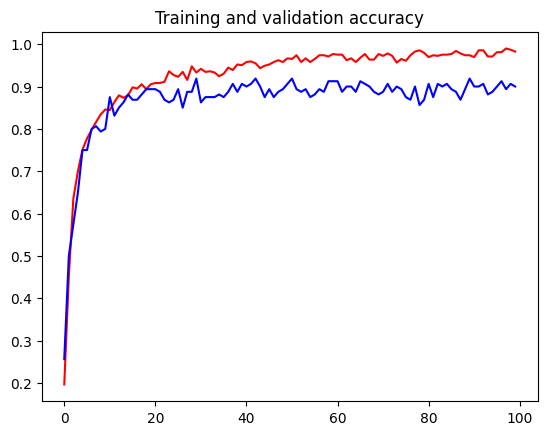

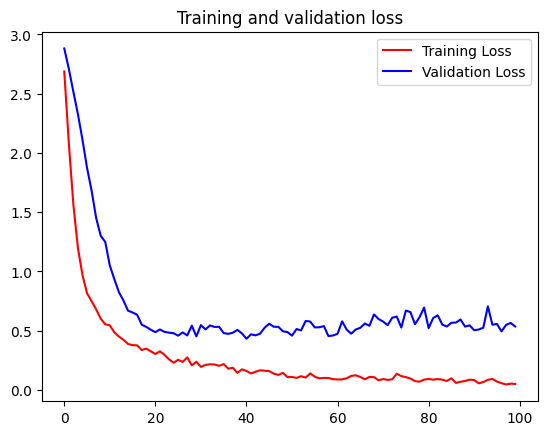

In [ ]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.optimizers import Adam

model1.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])

EPOCHS = 100

# Train the model
history1=model1.fit(
      train_generator,
      epochs=EPOCHS,validation_data=(valid_generator),
      verbose=2)

Epoch 1/100
22/22 - 21s - loss: 2.8420 - accuracy: 0.1674 - val_loss: 2.4016 - val_accuracy: 0.3562 - 21s/epoch - 933ms/step
Epoch 2/100
22/22 - 11s - loss: 2.4296 - accuracy: 0.3275 - val_loss: 1.8095 - val_accuracy: 0.4812 - 11s/epoch - 503ms/step
Epoch 3/100
22/22 - 13s - loss: 2.0340 - accuracy: 0.4672 - val_loss: 1.3568 - val_accuracy: 0.6812 - 13s/epoch - 590ms/step
Epoch 4/100
22/22 - 13s - loss: 1.7229 - accuracy: 0.5531 - val_loss: 1.1582 - val_accuracy: 0.6812 - 13s/epoch - 576ms/step
Epoch 5/100
22/22 - 13s - loss: 1.5490 - accuracy: 0.5779 - val_loss: 0.9232 - val_accuracy: 0.7688 - 13s/epoch - 575ms/step
Epoch 6/100
22/22 - 12s - loss: 1.4058 - accuracy: 0.6259 - val_loss: 0.8285 - val_accuracy: 0.8000 - 12s/epoch - 554ms/step
Epoch 7/100
22/22 - 12s - loss: 1.2908 - accuracy: 0.6725 - val_loss: 0.7486 - val_accuracy: 0.8313 - 12s/epoch - 542ms/step
Epoch 8/100
22/22 - 11s - loss: 1.1553 - accuracy: 0.7205 - val_loss: 0.6554 - val_accuracy: 0.8500 - 11s/epoch - 513ms/step


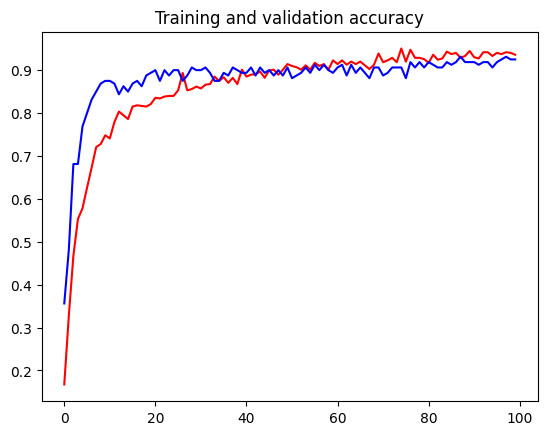

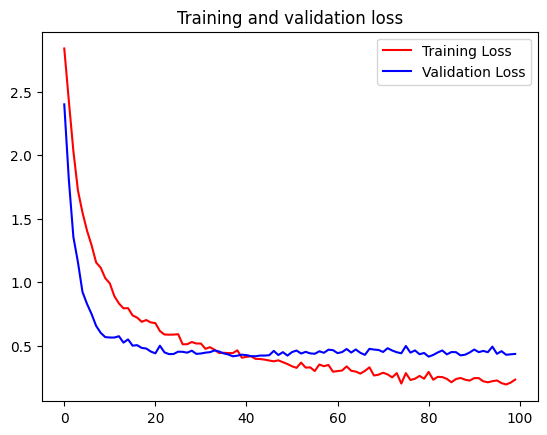

In [ ]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# creates a HDF5 file
model1.save(
    '/content/drive/MyDrive/Colab Notebooks/Parking System/output model/transfer_learning_trained_face_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing The Model

In [ ]:
from tensorflow.keras.models import load_model

# deletes the existing model
# del model

# returns a compiled model identical to the previous one
model = load_model(
    '/content/drive/MyDrive/Colab Notebooks/Parking System/output model/transfer_learning_trained_face_cnn_model.h5')


In [ ]:
import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {
    value:key for key, value in class_dictionary.items()
}
print(class_dictionary)


{0: 'Agus Dwi', 1: 'Agus Tresna', 2: 'Alisiya', 3: 'Ami', 4: 'Aul', 5: 'Dadi', 6: 'Gede Andhika', 7: 'Ibul', 8: 'Kak Utak', 9: 'Ken', 10: 'Melki', 11: 'Nanta', 12: 'Naufal Azmi', 13: 'Permadi', 14: 'Risman', 15: 'Ryan', 16: 'Saipul', 17: 'Sindang Alamsyah', 18: 'Tyok', 19: 'Zidan'}


In [ ]:
# save the class dictionary to pickle
face_label_filename = '/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/Salinan face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)


In [ ]:
import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = '/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/Salinan face-labels.pickle'
with open(face_label_filename, "rb") as \
    f: class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)


['Agus Dwi', 'Agus Tresna', 'Alisiya', 'Ami', 'Aul', 'Dadi', 'Gede Andhika', 'Ibul', 'Kak Utak', 'Ken', 'Melki', 'Nanta', 'Naufal Azmi', 'Permadi', 'Risman', 'Ryan', 'Saipul', 'Sindang Alamsyah', 'Tyok', 'Zidan']


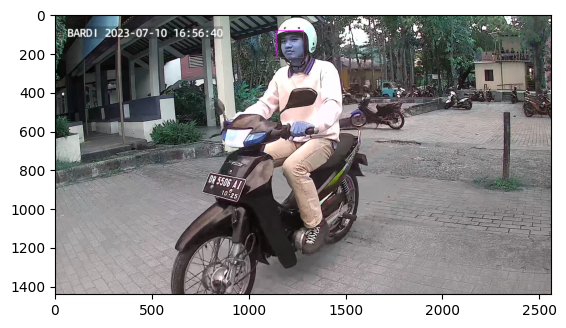

1/1 [==============================] - 0s 49ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
13
Predicted face: Permadi



In [ ]:
from keras.utils import img_to_array
# for detecting faces
facecascade =  cv2.CascadeClassifier(
    '/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/haarcascade_frontalface_default.xml')

# for i in range(1,4): test_image_filename = f'./content/drive/MyDrive/Colab Notebooks/Parking System/testing data/Arsan Testing{i}.jpg'
test_image_filename = '/content/drive/MyDrive/Colab Notebooks/Parking System/testing data/Pande.jpg'

# load the image
imgtest = cv2.imread(test_image_filename, cv2.IMREAD_COLOR)
image_array = np.array(imgtest, "uint8")

# get the faces detected in the image
faces = facecascade.detectMultiScale(imgtest,
    scaleFactor=1.1, minNeighbors=5)

# if not exactly 1 face is detected, skip this photo
if len(faces) != 1:
    print(f'---We need exactly 1 face; photo skipped---')
    print()

for (x_, y_, w, h) in faces:
    # draw the face detected
    face_detect = cv2.rectangle(
        imgtest, (x_, y_), (x_+w, y_+h), (255, 0, 255), 2)
    plt.imshow(face_detect)
    plt.show()

    # resize the detected face to 224x224
    size = (image_width, image_height)
    roi = image_array[y_: y_ + h, x_: x_ + w]
    resized_image = cv2.resize(roi, size)

    # prepare the image for prediction
    x = img_to_array(resized_image)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=1)

    # making prediction
    predicted_prob = model.predict(x)
    print(predicted_prob)
    print(predicted_prob[0].argmax())
    print("Predicted face: " + class_list[predicted_prob[0].argmax()])
    print("============================\n")



{0: 'Agus Dwi', 1: 'Agus Tresna', 2: 'Alisiya', 3: 'Ami', 4: 'Aul', 5: 'Dadi', 6: 'Gede Andhika', 7: 'Ibul', 8: 'Kak Utak', 9: 'Ken', 10: 'Melki', 11: 'Nanta', 12: 'Naufal Azmi', 13: 'Permadi', 14: 'Risman', 15: 'Ryan', 16: 'Saipul', 17: 'Sindang Alamsyah', 18: 'Tyok', 19: 'Zidan'}
1/1 [==============================] - 0s 146ms/step


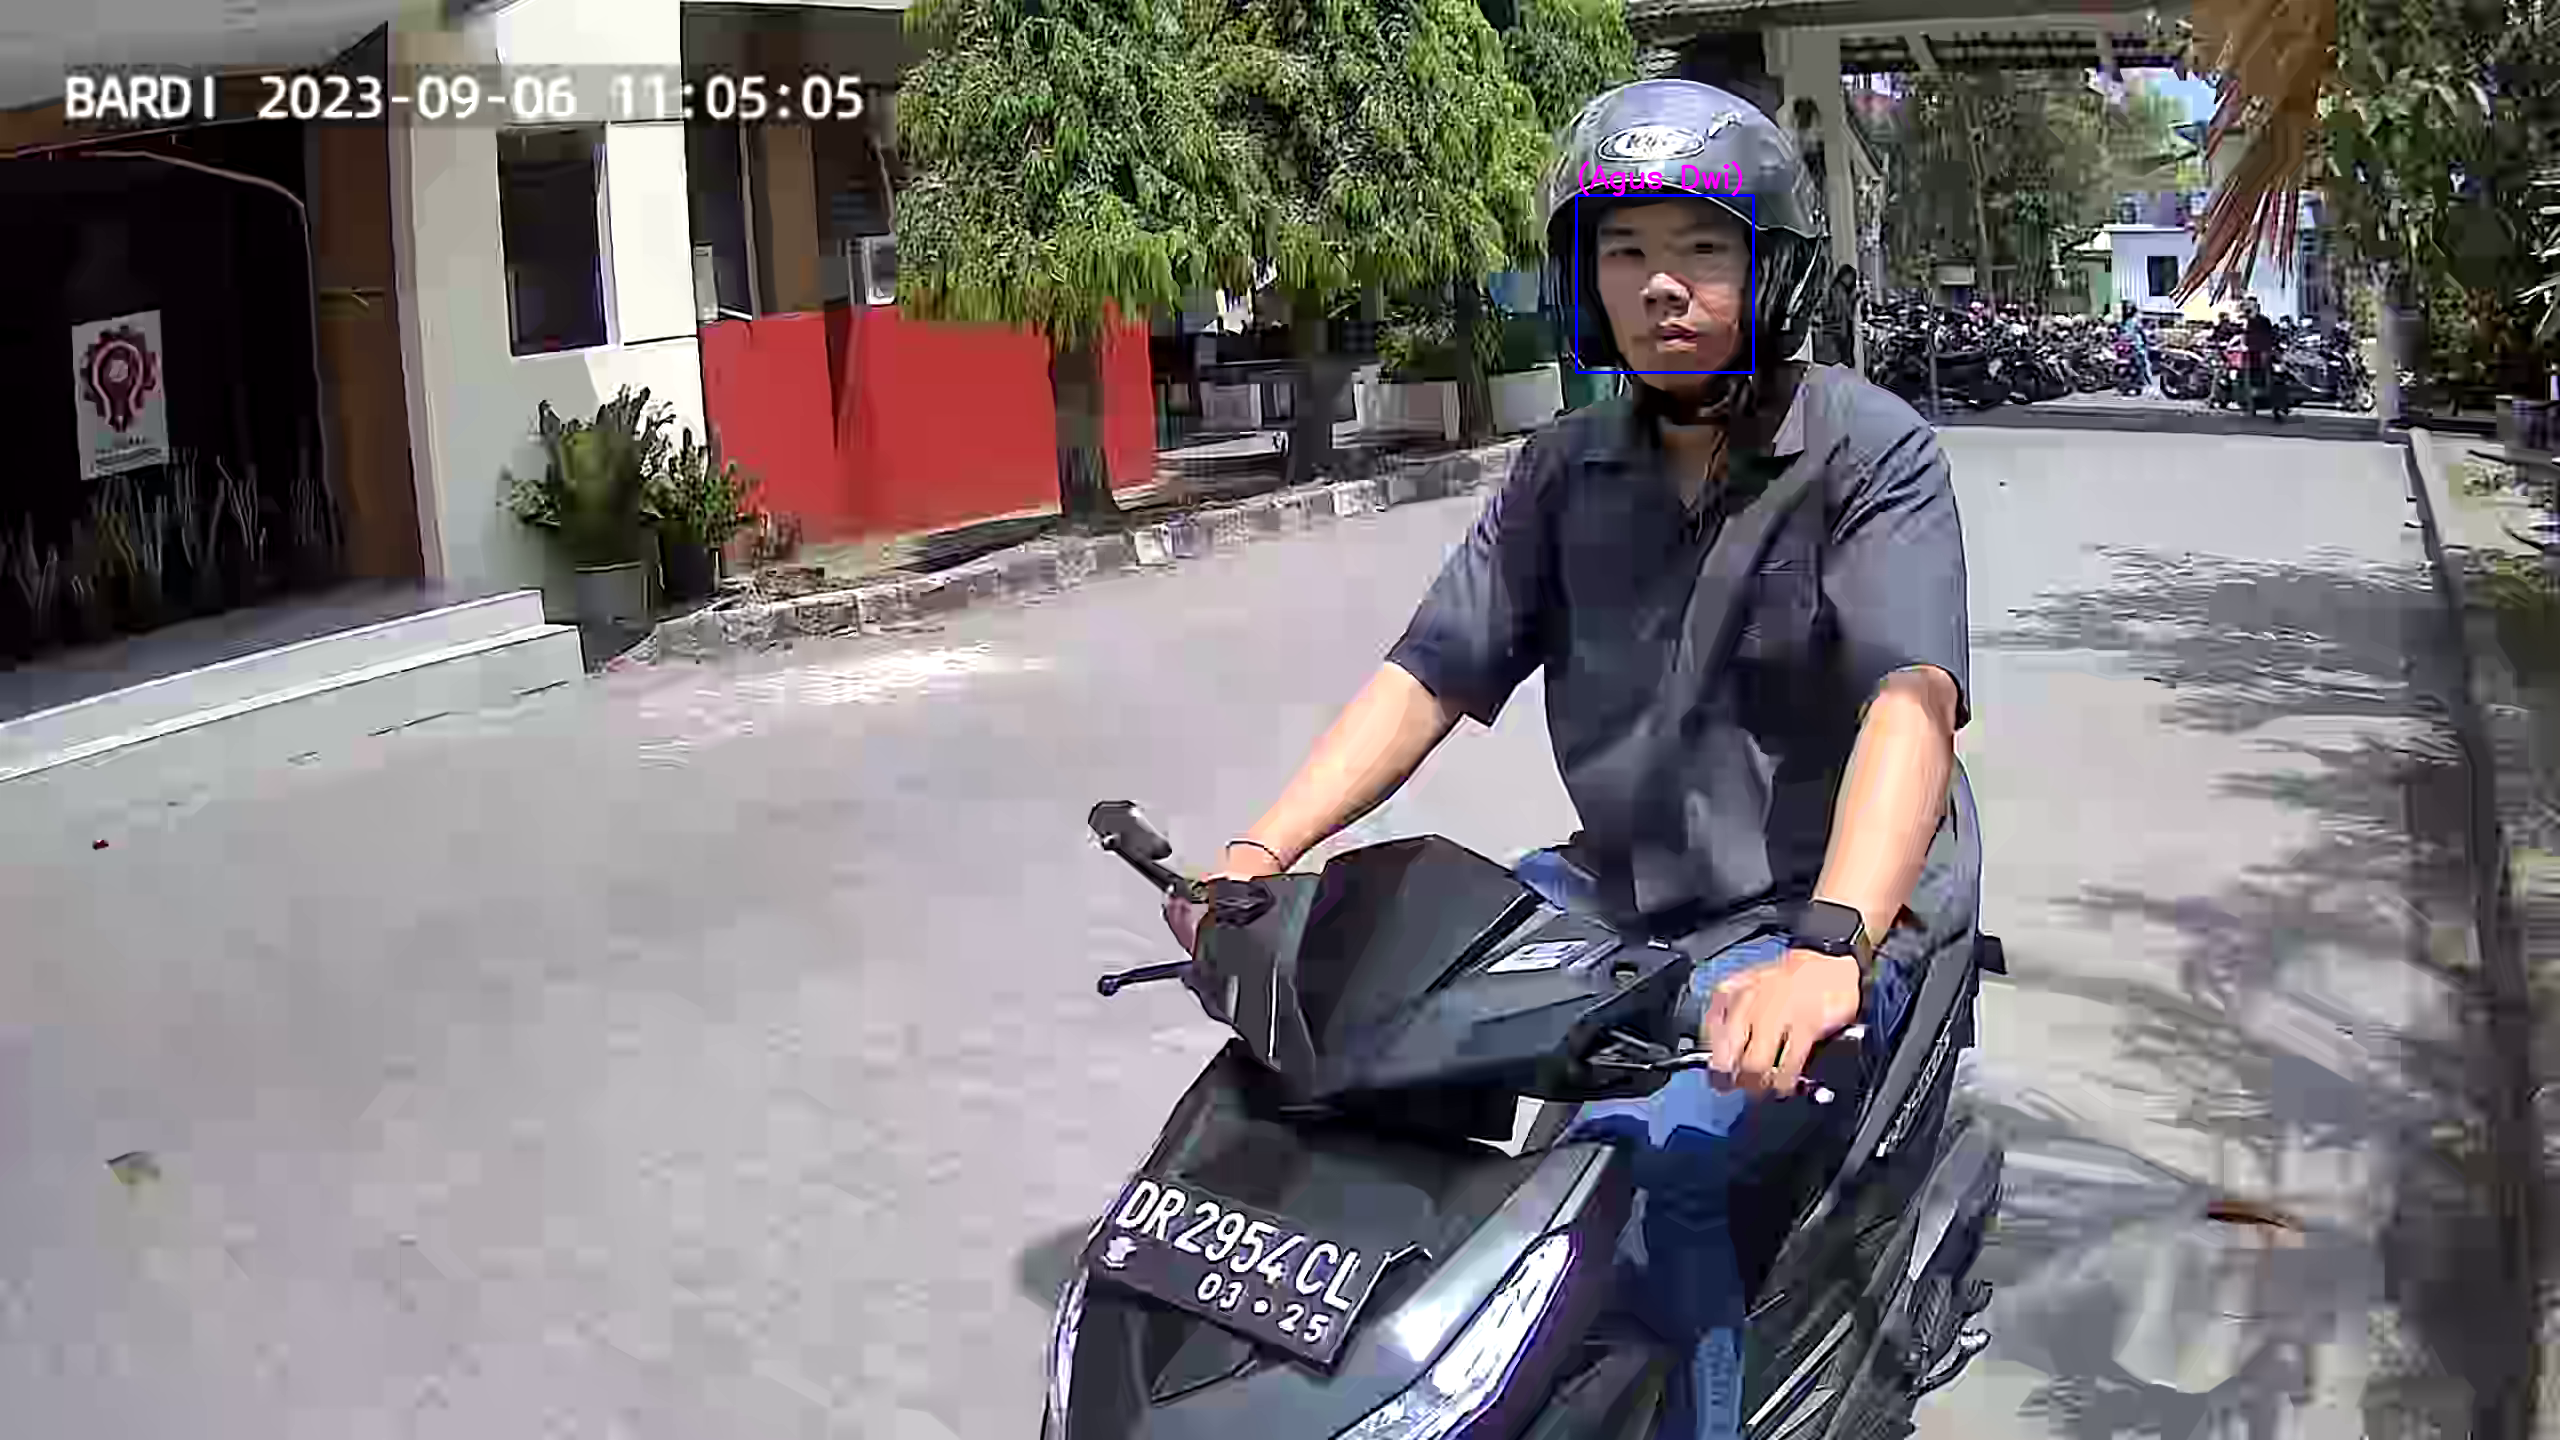

In [ ]:
from PIL import Image
import numpy as np
import cv2
import pickle
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images in Colab

# for face detection
face_cascade = cv2.CascadeClassifier(
    '/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/haarcascade_frontalface_default.xml')

# size of the image to predict
image_width = 224
image_height = 224

# load the trained model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Parking System/output model/transfer_learning_trained_face_cnn_model.h5')

# the labels for the trained model
with open("/content/drive/MyDrive/Colab Notebooks/Parking System/Wajah/Salinan face-labels.pickle", 'rb') as f:
    og_labels = pickle.load(f)
    labels = {key: value for key, value in og_labels.items()}
    print(labels)

# Open the MP4 video file
video_path = '/content/drive/MyDrive/Colab Notebooks/Parking System/testing data/Agus.mp4'
cap = cv2.VideoCapture(video_path)

# Define the output video settings
output_path = '/content/drive/MyDrive/Colab Notebooks/Parking System/output testing/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (640, 480))  # Change resolution as needed

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Break the loop if we have reached the end of the video
    if not ret:
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # try to detect faces in the frame
    faces = face_cascade.detectMultiScale(
        rgb, scaleFactor=1.3, minNeighbors=5)

    # for each face found
    for (x, y, w, h) in faces:
        roi_rgb = rgb[y:y+h, x:x+w]

        # Draw a rectangle around the face
        color = (255, 0, 0)  # in BGR
        stroke = 2
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, stroke)

        # resize the image
        size = (image_width, image_height)
        resized_image = cv2.resize(roi_rgb, size)
        image_array = np.array(resized_image, "uint8")
        img = image_array.reshape(1, image_width, image_height, 3)
        img = img.astype('float32')
        img /= 255

        # predict the image
        predicted_prob = model.predict(img)

        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        name = labels[predicted_prob[0].argmax()]
        color = (255, 0, 255)
        stroke = 2
        cv2.putText(frame, f'({name})', (x, y - 8),
                    font, 1, color, stroke, cv2.LINE_AA)

    # Write the frame to the output video
    out.write(frame)

    # Show the frame with predictions in Colab
    cv2_imshow(frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):  # Press q to break out of the loop
        break

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

